# Income Distribution Exploritory Data Analysis
The US Census Bureau has data on the distribution of wages for various US groups. How have these distributions changed over time?

Lets import the data, clean it up, then do an initial plot to see what we are working with. 

## Import the data

In [71]:

import numpy as np
import pandas as pd
import os
import matplotlib as plt 
import seaborn as sns 

folder_path = '/Users/Curra/Documents/repos/wage_distribution/Data'


dataframes = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and "ACSST1Y" in file_name:
        try:
            # Extract the year from the filename
            year = file_name.split("ACSST1Y")[1][:4]  

            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)  

            df['Year'] = year
            
            dataframes.append(df)
        except (IndexError, ValueError):
            print(f"Skipping file due to unexpected format: {file_name}")

combined_data = pd.concat(dataframes, ignore_index=True)


## Clean the Data

In [72]:
# Rename the columns
new_column_names = {
    "Label (Grouping)": "label_grouping",
    "United States!!Households!!Estimate": "households_estimate",
    "United States!!Households!!Margin of Error": "households_margin_of_error",
    "United States!!Families!!Estimate": "families_estimate",
    "United States!!Families!!Margin of Error": "families_margin_of_error",
    "United States!!Married-couple families!!Estimate": "married_couple_families_estimate",
    "United States!!Married-couple families!!Margin of Error": "married_couple_families_margin_of_error",
    "United States!!Nonfamily households!!Estimate": "nonfamily_households_estimate",
    "United States!!Nonfamily households!!Margin of Error": "nonfamily_households_margin_of_error"
}

combined_data.rename(columns=new_column_names, inplace=True)

# Replace '%' and '±' symbols in all columns
cleaned_data = combined_data.copy()

for col in cleaned_data.columns:
    if cleaned_data[col].dtype == 'object':
        cleaned_data[col] = (
            cleaned_data[col]
            .str.replace('%', '', regex=False)  # Remove percentage symbols
            .str.replace('±', '', regex=False)  # Remove ± symbols
            .str.replace(',', '', regex=False)  # Remove commas
        )

# Strip whitespace in label_grouping
cleaned_data["label_grouping"] = cleaned_data["label_grouping"].str.strip()

# Convert numeric columns to appropriate types
numeric_columns = [
    "households_estimate",
    "households_margin_of_error",
    "families_estimate",
    "families_margin_of_error",
    "married_couple_families_estimate",
    "married_couple_families_margin_of_error",
    "nonfamily_households_estimate",
    "nonfamily_households_margin_of_error"
]

for col in numeric_columns:
    if col in cleaned_data.columns:
        cleaned_data[col] = pd.to_numeric(cleaned_data[col], errors='coerce')  # Convert to numeric

# Function to filter rows
def clean_data(cleaned_data):
    cleaned_data = cleaned_data[
        (cleaned_data['label_grouping'].str.contains("total", regex=False, na=False)) | 
        (cleaned_data['label_grouping'].str.contains("$", regex=False, na=False))
    ]
    return cleaned_data

# Apply filtering
cleaned_data = clean_data(cleaned_data)



# Check the first few rows
#cleaned_data.head(15)

## Plot the Data

C:\Users\Curra\AppData\Local\Temp\ipykernel_13372\3203590027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Year'] = plot_data['Year'].astype(int)
c:\Users\Curra\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\Curra\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Ridgeline Plot of Household Estimates 2010 - 2023')

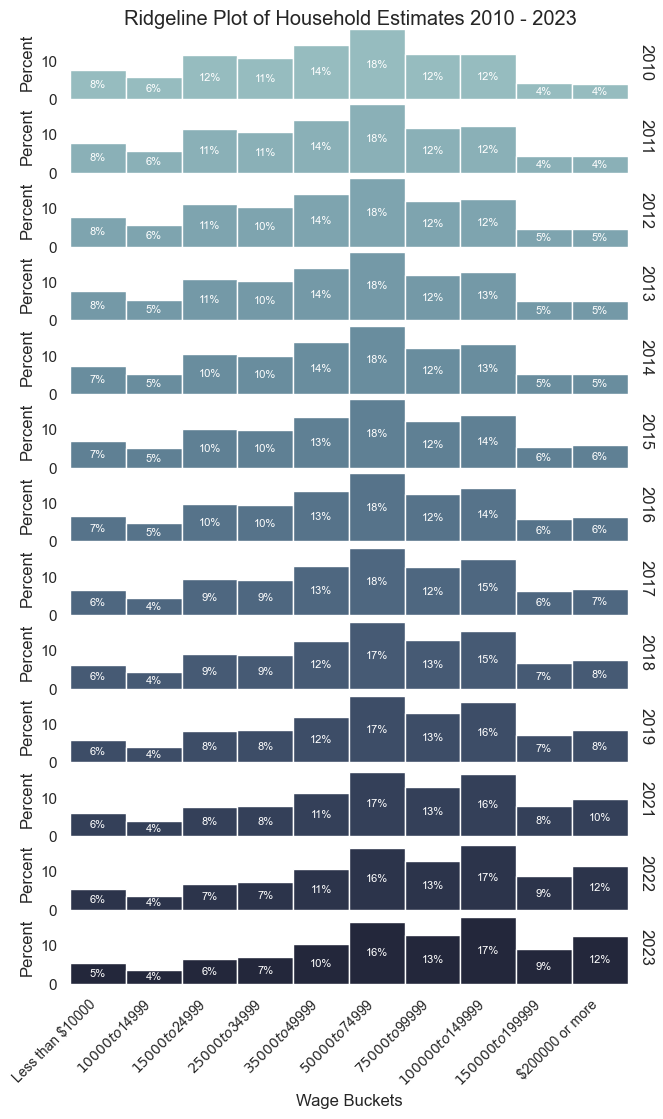

In [73]:
columns_to_plot = ['label_grouping', 'households_estimate', 'Year']
plot_data = cleaned_data[columns_to_plot]
plot_data['Year'] = plot_data['Year'].astype(int)
labels = [
    'Less than $10000',
    '$10000 to $14999',
    '$15000 to $24999',
    '$25000 to $34999',
    '$35000 to $49999',
    '$50000 to $74999',
    '$75000 to $99999',
    '$100000 to $149999',
    '$150000 to $199999',
    '$200000 or more'
]
#print(plot_data.head(15))

# Theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(len(plot_data["Year"].unique()), rot=-.25, light=.7)

# Initialize the FacetGrid object
g = sns.FacetGrid(
    plot_data, 
    row='Year', 
    hue='Year', 
    height=0.8, 
    aspect=8,
    palette=pal,
    margin_titles=True,
)

# Map the data to the FacetGrid
g.map(
    sns.barplot,
    'label_grouping', 
    'households_estimate',
    width=1,
)

# Add annotations to the bars
def annotate_bars(ax):
    for p in ax.patches:  # Iterate over all bars
        value = p.get_height()
        if not pd.isna(value):  # Check if value is not NaN
            ax.text(
                p.get_x() + p.get_width() / 2,  # X-coordinate: center of the bar
                value / 2,  # Y-coordinate: middle of the bar
                f'{value:.0f}%',  # Format the value
                ha='center', va='center', color='white', fontsize=8  # Styling
            )

# Apply the annotation function to each subplot
for ax in g.axes.flat:
    annotate_bars(ax)

# Clean up the plot
g.set_axis_labels('Wage Buckets', "Percent")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.figure.subplots_adjust(wspace=0, hspace=0)
# Rotate x-axis labels for readability
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xticks(range(len(labels)))  
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)  
g.despine(bottom=True, left=True)
g.figure.suptitle('Ridgeline Plot of Household Estimates 2010 - 2023')

# Review
Well this is interesting, but not particularly helpful. It's hard to read for each group over time, requiring us to jump from 2010-2023 over and over again to measure the changes.

I wonder if we can flip these, to plot as a line graph and that might be more informative?

# Plotting Round 2

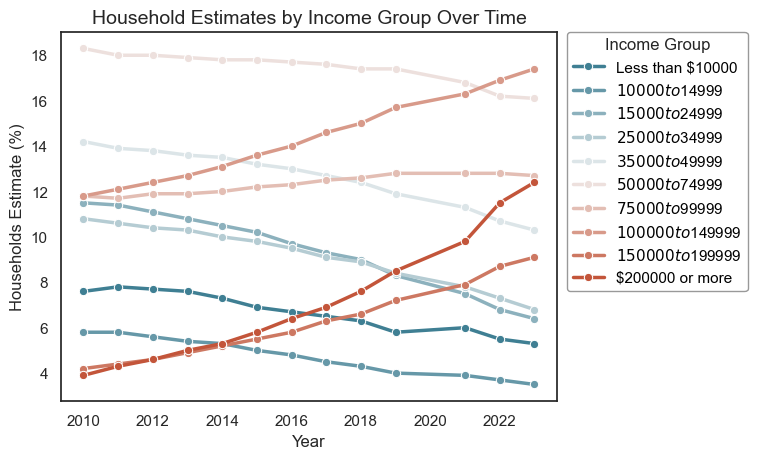

In [74]:

g = sns.lineplot(
    plot_data,
    x='Year',
    y='households_estimate', 
    hue='label_grouping',
    marker='o',
    palette = sns.diverging_palette(220, 20, n=plot_data['label_grouping'].nunique(), as_cmap=False),
    linewidth=2.5
)

g.set_title("Household Estimates by Income Group Over Time", fontsize=14)
g.set_xlabel("Year", fontsize=12)
g.set_ylabel("Households Estimate (%)", fontsize=12)

# Adjusting the legend
g.legend(
    title="Income Group",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=True
)
# Legend Apperance
legend = g.legend_
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("gray")
for text in legend.get_texts():
    text.set_color("black")


# Review Round 2
Ok we are getting somewhere! No where quantifiable, but somewhere where we can identify a trend!
From the above graph it's clear to see the higher income brackets (red) gaining percentage share in the total population, while lower income brackets (blue) are generally declining.

With this information we can state that wages in the US are going up from 2010-2023, and more people are making more money. I still have a few questions:
1. How much?
2. Which groups changed the most?
3. What is the spread? Has it widened or narrowed?
4. Is this trend only a recent one?
5. Does the decline in the lower groups inversly match the increase in the higher groups? 

Some of these questions are easier to answer then others. Lets start with those:

2. What groups changed the most?
For this we can take each wage groups most recent value, and subtract the earliest value, getting the change over the full period:

In [75]:
# Filter datafrome to just years we care about
filtered_df = plot_data.loc[plot_data["Year"].isin([2010, 2023])]

# Pivot the dataframe
pivoted_df = filtered_df.pivot(index='label_grouping', columns='Year', values='households_estimate')

# Add new column with difference:
pivoted_df['Difference'] = pivoted_df[2023] - pivoted_df[2010]

sort_order = [
    "Less than $10000", "$10000 to $14999", "$15000 to $24999",
    "$25000 to $34999", "$35000 to $49999", "$50000 to $74999",
    "$75000 to $99999", "$100000 to $149999", "$150000 to $199999",
    "$200000 or more"
]
result_df = pivoted_df.reset_index()

result_df['label_grouping'] = pd.Categorical(result_df['label_grouping'], categories=sort_order, ordered=True)

result_df = result_df.sort_values(by='label_grouping')
#result_df.sort_values(by='Difference', ascending=True, inplace=True)

print(result_df)

Year      label_grouping  2010  2023  Difference
9       Less than $10000   7.6   5.3        -2.3
0       $10000 to $14999   5.8   3.5        -2.3
2       $15000 to $24999  11.5   6.4        -5.1
5       $25000 to $34999  10.8   6.8        -4.0
6       $35000 to $49999  14.2  10.3        -3.9
7       $50000 to $74999  18.3  16.1        -2.2
8       $75000 to $99999  11.8  12.7         0.9
1     $100000 to $149999  11.8  17.4         5.6
3     $150000 to $199999   4.2   9.1         4.9
4        $200000 or more   3.9  12.4         8.5


From this we can see that all the lower wage groups below $75,000 had a reduction from 2010, while all the groups above $75,000 had an increase!

Lets try to work on the spread:

3. What is the spread? Has it widened or narrowed?

This dataset isn't a true distribution, with datapoints having specific values. Instead it's a summary dataset just showing the proportion of households in wage buckets set by the Census Bureau by year. With only the summary values calculating a true minimum, maximum, and average will not be possible. We just don't know the underlying values, just the summaries. 

We can recreate an estimate of the median. We know that in 2023, 5.3% of households belonged to the "Less then $10,000" bucket. We can assume a population of 1000 and state that 53 households out of 1000 made less that $10,000. From there the standard median calculation is the same.

**Note**: *This median will not be very accurate, as it will only state what wage bucket the median resides in, but it might show changes over time broadly.*

In [76]:
# Create population column
plot_data['population'] = plot_data['households_estimate'] * 10
#plot_data.head(10)


# Function to find the median label_grouping for each year
def calculate_median_label_grouping(df):
    result = []  # To store the closest label_grouping for each row
    for year in plot_data['Year'].unique():  # Iterate over each unique year
        year_data = plot_data[plot_data['Year'] == year]  # Filter data for the current year
        median_population = year_data['population'].median()  # Calculate median population
        # Find the label_grouping closest to the median
        closest_label = year_data.loc[
            (year_data['population'] - median_population).abs().idxmin(), 'label_grouping'
        ]
        # Append the closest label for all rows in that year
        result.extend([closest_label] * len(year_data))
    return result

# Apply the function to calculate the plot_data column
plot_data['median_label'] = calculate_median_label_grouping(plot_data)

# Print our new label
plot_data.head(10)


C:\Users\Curra\AppData\Local\Temp\ipykernel_13372\3494421581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['population'] = plot_data['households_estimate'] * 10
C:\Users\Curra\AppData\Local\Temp\ipykernel_13372\3494421581.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['median_label'] = calculate_median_label_grouping(plot_data)


,label_grouping,households_estimate,Year,population,median_label
1,Less than $10000,7.6,2010,76.0,$15000 to $24999
2,$10000 to $14999,5.8,2010,58.0,$15000 to $24999
3,$15000 to $24999,11.5,2010,115.0,$15000 to $24999
4,$25000 to $34999,10.8,2010,108.0,$15000 to $24999
5,$35000 to $49999,14.2,2010,142.0,$15000 to $24999
6,$50000 to $74999,18.3,2010,183.0,$15000 to $24999
7,$75000 to $99999,11.8,2010,118.0,$15000 to $24999
8,$100000 to $149999,11.8,2010,118.0,$15000 to $24999
9,$150000 to $199999,4.2,2010,42.0,$15000 to $24999
10,$200000 or more,3.9,2010,39.0,$15000 to $24999


Aside from an issue in my code for 2021, we can see that the median has shifted up two groups from "$15,000-24,999" to "$35,000-49,000".

Another idea I have is 
